# **Data Challenge: Identify Benign vs. Malignant Cells**
The aim of this project is to build a algorithm that can classify biopsied breast cells as being in one of two classes; benign (non-cancerous) or malignant (cancerous). The data consists of 11 features of the biopsied cells. Given a new sample (with its associated features), the goal is to predict the class.
<br><br> Below are the features (columns) of the dataset:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)


The first column (ID number) is just a label given to each sample, so won't be useful in predicting the class. Columns 2 through 10 are the physical attributes of the cells which we will use in building our model. The final column, class, is the category to which the sample belongs (benign or malignant).

## Step 1: Import Data 

First we will import all our required packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn import metrics

/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<br>Now import the data and give the columns descriptive titles:

In [2]:
# read in the data and label columns 
cells = pd.read_csv("breast-cancer-wisconsin.data", header = None, names = ['ID','cl_thick','uni_cell_size',
                                                                           'uni_cell_sh','mar_ad','s_size',
                                                                           'b_nuc','bl_ch','nor_nuc','mit',
                                                                           'classtype'])

## Step 2: Explore and visualize the data

<br>Take a look at the first few rows of data to make sure our import went OK: 

In [3]:
cells.head()

,ID,cl_thick,uni_cell_size,uni_cell_sh,mar_ad,s_size,b_nuc,bl_ch,nor_nuc,mit,classtype
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


<br> See how many rows of data we have:

In [4]:
# shape
print(cells.shape)

(699, 11)


<br> And get some statistics about the features:

In [5]:
# descriptions
print(cells.describe())

                 ID    cl_thick  uni_cell_size  uni_cell_sh      mar_ad  \
count  6.990000e+02  699.000000     699.000000   699.000000  699.000000   
mean   1.071704e+06    4.417740       3.134478     3.207439    2.806867   
std    6.170957e+05    2.815741       3.051459     2.971913    2.855379   
min    6.163400e+04    1.000000       1.000000     1.000000    1.000000   
25%    8.706885e+05    2.000000       1.000000     1.000000    1.000000   
50%    1.171710e+06    4.000000       1.000000     1.000000    1.000000   
75%    1.238298e+06    6.000000       5.000000     5.000000    4.000000   
max    1.345435e+07   10.000000      10.000000    10.000000   10.000000   

           s_size       bl_ch     nor_nuc         mit   classtype  
count  699.000000  699.000000  699.000000  699.000000  699.000000  
mean     3.216023    3.437768    2.866953    1.589413    2.689557  
std      2.214300    2.438364    3.053634    1.715078    0.951273  
min      1.000000    1.000000    1.000000    1.00000

<br> How many samples do we have of each class?

In [6]:
# class distribution
print(cells.groupby('classtype').size())

classtype
2    458
4    241
dtype: int64


<br>Hmmmm....those classes are fairly unbalanced, we will have to remember to take care of that later...

<br><br> Now we'll look at the distributions of our features as well as their correlation with one another:

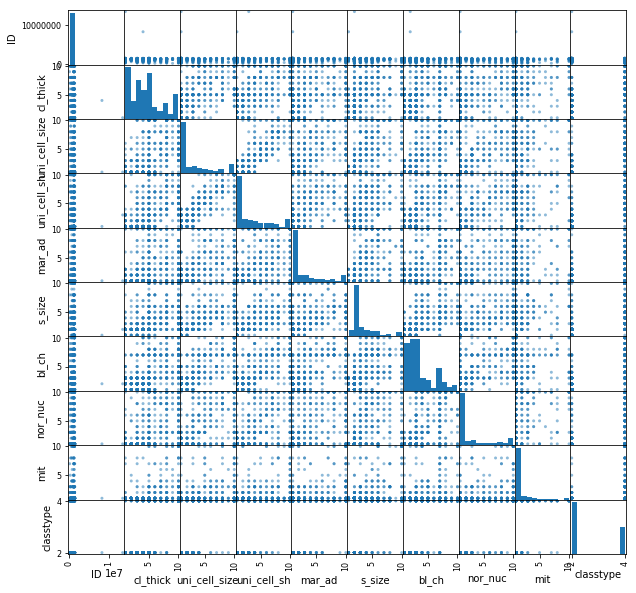

In [7]:
# scatter plot matrix
scatter_matrix(cells, figsize=(10,10))
plt.show()

<br> First thing to notice is that all of our features have very non-normal distributions--we will have to keep this in mind when we are choosing a model later on. It also looks like "Uniform_cell_size" is pretty correlated with "Uniform_cell_shape"...we will double check this correlation using a heatmap:

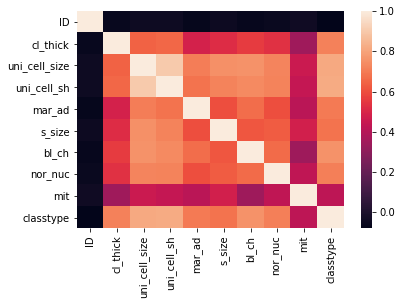

In [8]:
corr = cells.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

<br> We also want to look at our features and make sure there is a difference in distributions between the two classes, so let's look at histograms of each feature for each class and see if they look more or less different:

classtype
2    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
4    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

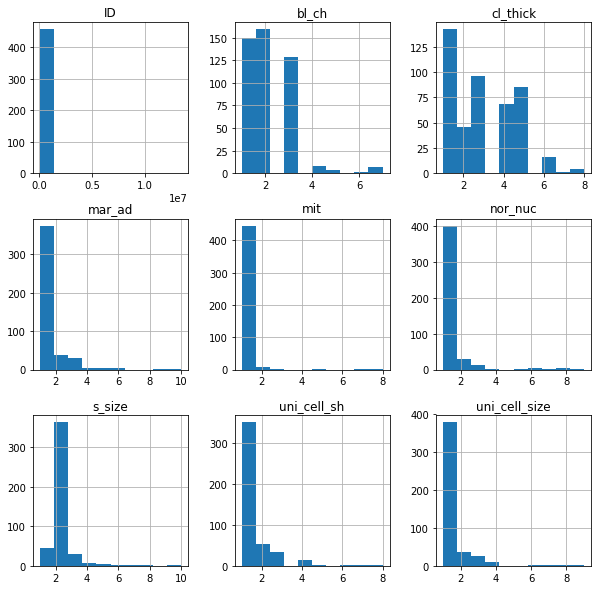

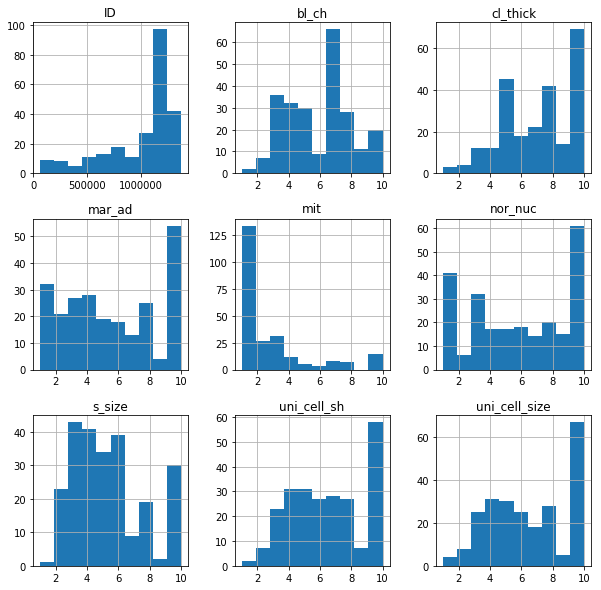

In [9]:
cells.groupby('classtype').hist(figsize=(10,10))

<br> The distributions look pretty different, with "Mitoses" looking the least different--we may think about removing that feature in the future.

## Step 3: Clean the data

<br> The heatmap confirmed that "uniform_cell_size" and "uniform_cell_shape" are correlated. We probably only need to keep one of these, since they are providing similar information. I want to keep the one with the largest variance, since that will account for more possibilities in new, unseen data. Looking at the statistical descriptions of the features above, we see that "uniform_cell_shape" has a lower standard deviation, so we'll remove it: 

In [10]:
cells.drop(columns = 'uni_cell_sh', inplace = True)

<br>Now let's look for NAs in the data:

In [11]:
cells.isnull().any()

ID               False
cl_thick         False
uni_cell_size    False
mar_ad           False
s_size           False
b_nuc            False
bl_ch            False
nor_nuc          False
mit              False
classtype        False
dtype: bool

<br> Looks good! <br> Now we want to make sure the datatypes are correct:

In [12]:
cells.dtypes

ID                int64
cl_thick          int64
uni_cell_size     int64
mar_ad            int64
s_size            int64
b_nuc            object
bl_ch             int64
nor_nuc           int64
mit               int64
classtype         int64
dtype: object

<br> It looks like "b_nuc", or Bare Nuclei is currently coded as object type, but should probably be an integer type, since it is a count of the number of nuclei. It turns out that it is currently coded as an object type because it contains non-number values (question-marks where there are missing values). Since there are not many rows with question-marks, let's just get rid of those rows:

In [13]:
cells = cells[cells['b_nuc'] != '?']
cells.b_nuc = cells.b_nuc.astype(int)
len(cells)

683

<br> We're also going to change the classes to 0 and 1 instead of 2 and 4 since it's more intuitive:

In [14]:
d = {4: 1, 2: 0}
cells['intclasstype'] = cells['classtype'].map(d).astype(int)

## Step 4: Choose a model!

<br> First thing we need to do is split up the data into a training and test set:

In [15]:
# Split-out test data
array = cells.values  # convert to an array
X = array[:,1:9]
Y = array[:,10]
validation_size = 0.20
seed = 7
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y,
                                                                    test_size=validation_size,
                                                                    random_state=seed)

<br> We know from above that our benign class has about twice as many samples as the malignant class, so we should upsample the malignant class. We will use SMOTE to do this:

In [16]:
sm = SMOTE(random_state=12, ratio = 'minority')  # this says we want to upsample the minority class
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

<br> Ok, we are going to try three different algorithms and see which one performs the best. But to do this we want to use cross-validation so we are not overfitting to our training data. To determine which one works best, we are going to use recall, since we want to make sure that we catch every case of cancer. We are still somewhat concerned with precision (making sure that every case we call cancer actually is cancer), but we are willing to accept lower precision in exchange for higher recall since a false positive is not life-threatening (assuming the patient will go for multiple tests, one of which will catch the false positive).
<br><br>
The three algorithms we are going to try are K-nearest neighbours, Random Forest classifer, and a Support Vector Machine. I chose these because they do not require normally-distributed data and work well on small datasets (with the exception of Random Forest).

In [20]:
# make a list of possible algorithms
scoring = 'recall'
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('SVM', SVC(class_weight='balanced')))
# evaluate each model in turn
results = []
names = []
lb = preprocessing.LabelBinarizer()
y2 = np.array([number[0] for number in lb.fit_transform(y_train_res)])
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x_train_res, y2, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.995238 (0.014286)
RFC: 0.975700 (0.031873)
SVM: 0.995238 (0.014286)


<br> It looks like K-nearest neighbours and SVM have identical recall during cross validation, so we will just choose SVM. Now let's see how it works on the test-set:

In [21]:
# Make predictions on validation dataset
mysvm = SVC()
mysvm.fit(x_train_res, y_train_res)
predictions = mysvm.predict(X_test)
svmscore = mysvm.score(X_test, Y_test)
print(classification_report(Y_test, predictions))

             precision    recall  f1-score   support

          0       1.00      0.93      0.97        89
          1       0.89      1.00      0.94        48

avg / total       0.96      0.96      0.96       137



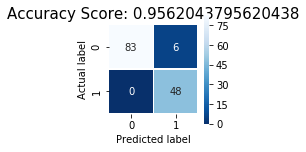

In [22]:
# make confusion matrix
cm = metrics.confusion_matrix(Y_test, predictions)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(svmscore)
plt.title(all_sample_title, size = 15);

## Step 5: Conclusions

Our Support Vector Machine works well to classify cells as being benign or malignant. On our test data, we had no cases of cancer that were missed, which is good. We did have 6 cases of benign cells that were classified as malignant, but as explained above, we would hope that multiple tests would eventually identify these as actually being benign.